In [83]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name()}")

PyTorch version: 2.6.0+cu126
CUDA available: True
Current GPU device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [84]:
import pytorch_lightning as pl
import pytorch_forecasting
print("PyTorch Lightning version:", pl.__version__)
print("PyTorch Forecasting version:", pytorch_forecasting.__version__)


PyTorch Lightning version: 2.5.1
PyTorch Forecasting version: 1.3.0


In [85]:
import os
import yfinance as yf
import pandas as pd
import time

excel_filename = "GOOGL_data.xlsx"
feather_filename = "GOOGL_data.feather"
max_retries = 5  # Number of retries before falling back
retry_delay = 5  # Seconds to wait before retrying

def fetch_data_with_retries(ticker, period, interval, retries, delay):
    for attempt in range(retries):
        try:
            print(f"Attempt {attempt + 1}: Fetching data from yfinance...")
            data = yf.download(ticker, period=period, interval=interval)
            if not data.empty:
                return data
            print("Warning: Retrieved empty data, retrying...")
        except Exception as e:
            print(f"Error fetching data: {e}, retrying in {delay} seconds...")
        time.sleep(delay)
    return None

# Try fetching data with retries
data_google = fetch_data_with_retries("GOOGL", period="max", interval="1d", retries=max_retries, delay=retry_delay)

if data_google is not None:
    data_google.reset_index(inplace=True)
    
    # Ensure no MultiIndex columns
    if isinstance(data_google.columns, pd.MultiIndex):
        data_google.columns = ['_'.join(col).strip() for col in data_google.columns.values]
    
    data_google.to_excel(excel_filename, index=False, engine="openpyxl")
    data_google.to_feather(feather_filename)
    print(f"Data successfully fetched and saved to '{excel_filename}' and '{feather_filename}'.")
else:
    print("All retry attempts failed. Falling back to stored data.")
    if os.path.exists(feather_filename):
        print(f"Loading data from existing Feather file '{feather_filename}'...")
        data_google = pd.read_feather(feather_filename)
    elif os.path.exists(excel_filename):
        print(f"Loading data from existing Excel file '{excel_filename}'...")
        data_google = pd.read_excel(excel_filename, engine="openpyxl")
    else:
        print("No stored data found. Data retrieval failed.")
        data_google = None

# Display the first few rows of the dataset if available
if data_google is not None:
    print(data_google.head())


Attempt 1: Fetching data from yfinance...


[*********************100%***********************]  1 of 1 completed


Data successfully fetched and saved to 'GOOGL_data.xlsx' and 'GOOGL_data.feather'.
       Date_  Close_GOOGL  High_GOOGL  Low_GOOGL  Open_GOOGL  Volume_GOOGL
0 2004-08-19     2.499063    2.591713   2.389974    2.490595     893181924
1 2004-08-20     2.697563    2.716741   2.503048    2.515750     456686856
2 2004-08-23     2.724711    2.826327   2.715994    2.758334     365122512
3 2004-08-24     2.611887    2.779504   2.579509    2.770538     304946748
4 2004-08-25     2.640031    2.689843   2.587231    2.614129     183772044


In [86]:
# Ensure proper indexing
data_google.rename(columns={"Date_": "Date"}, inplace=True)

if 'Date' in data_google.columns:
    print(data_google['Date'].head())

# Rename columns only if MultiIndex is present
if isinstance(data_google.columns, pd.MultiIndex):
    data_google.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_google.columns]

# Drop redundant 'index' column if present
if 'index' in data_google.columns:
    data_google = data_google.drop(columns=['index'])

# Create time index and group identifier
data_google['time'] = range(len(data_google))
data_google['group'] = 'GOOGL'

# Print updated column names
print(data_google.columns)


0   2004-08-19
1   2004-08-20
2   2004-08-23
3   2004-08-24
4   2004-08-25
Name: Date, dtype: datetime64[ns]
Index(['Date', 'Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL',
       'Volume_GOOGL', 'time', 'group'],
      dtype='object')


In [87]:
# --- Data Quality Improvements Begin Here ---
import pandas as pd
# Check if 'Date' is in columns; if not, reset the index again
if 'Date' not in data_google.columns:
    data_google.reset_index(inplace=True)
    print("After resetting index, columns:", data_google.columns)

# Convert 'Date' to datetime
data_google['Date'] = pd.to_datetime(data_google['Date'])

# Continue with sorting and further cleaning
data_google.sort_values('Date', inplace=True)
data_google.reset_index(drop=True, inplace=True)

# Check for missing values and fill them
print("Missing values per column:")
print(data_google.isnull().sum())
data_google.fillna(method='ffill', inplace=True)

# Remove duplicate rows
data_google.drop_duplicates(inplace=True)

# Outlier removal (example for key numerical columns)
from scipy import stats
import numpy as np
for col in ['Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL']:
    z_scores = np.abs(stats.zscore(data_google[col]))
    data_google = data_google[z_scores < 3]

# Feature engineering: Extract additional date features
data_google['year'] = data_google['Date'].dt.year
data_google['month'] = data_google['Date'].dt.month
data_google['day'] = data_google['Date'].dt.day
data_google['weekday'] = data_google['Date'].dt.weekday
data_google['month_sin'] = np.sin(2 * np.pi * data_google['month'] / 12)
data_google['month_cos'] = np.cos(2 * np.pi * data_google['month'] / 12)
data_google['weekday_sin'] = np.sin(2 * np.pi * data_google['weekday'] / 7)
data_google['weekday_cos'] = np.cos(2 * np.pi * data_google['weekday'] / 7)

# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
num_cols = ['Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL']
scaler = MinMaxScaler()
data_google[num_cols] = scaler.fit_transform(data_google[num_cols])

print("Data quality improvements complete.")
print(data_google.head())


Missing values per column:
Date            0
Close_GOOGL     0
High_GOOGL      0
Low_GOOGL       0
Open_GOOGL      0
Volume_GOOGL    0
time            0
group           0
dtype: int64
Data quality improvements complete.
        Date  Close_GOOGL  High_GOOGL  Low_GOOGL  Open_GOOGL  Volume_GOOGL  \
1 2004-08-20     0.001127    0.000988   0.000214    0.000248      0.818469   
2 2004-08-23     0.001275    0.001580   0.001385    0.001574      0.650953   
3 2004-08-24     0.000660    0.001327   0.000634    0.001641      0.540862   
4 2004-08-25     0.000813    0.000843   0.000677    0.000786      0.319173   
5 2004-08-26     0.001073    0.000836   0.000784    0.000784      0.242565   

   time  group  year  month  day  weekday  month_sin  month_cos  weekday_sin  \
1     1  GOOGL  2004      8   20        4  -0.866025       -0.5    -0.433884   
2     2  GOOGL  2004      8   23        0  -0.866025       -0.5     0.000000   
3     3  GOOGL  2004      8   24        1  -0.866025       -0.5     0.7

C:\Users\deepa\AppData\Local\Temp\ipykernel_20912\2683719975.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_google.fillna(method='ffill', inplace=True)


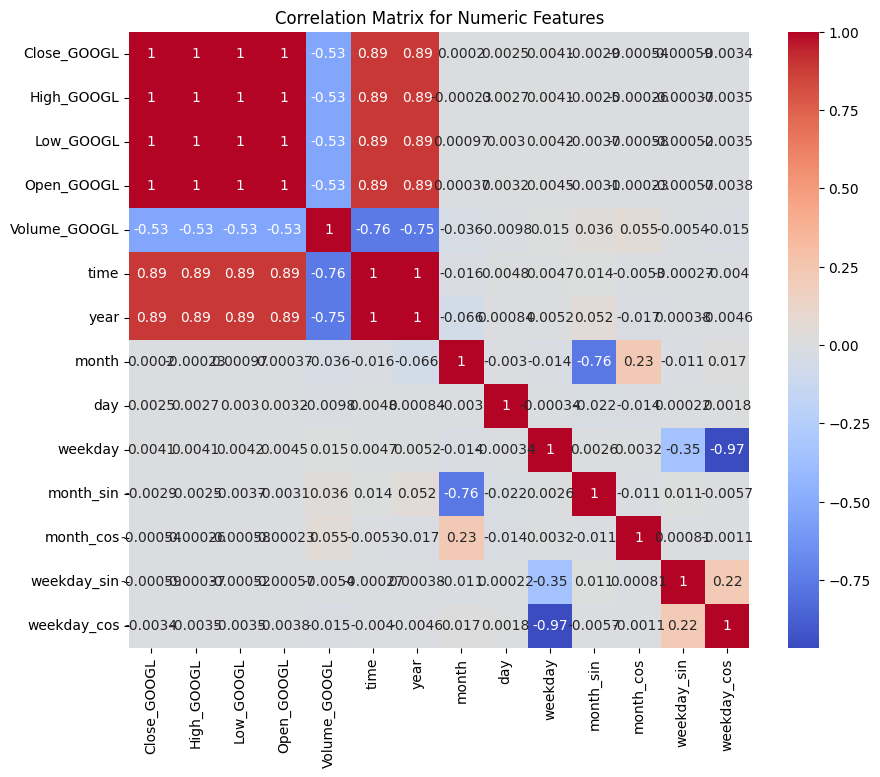

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_data = data_google.select_dtypes(include=[float, int])

# Compute the correlation matrix for numeric features
corr_matrix = numeric_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()


In [89]:
# %% [Cell 5.1] - Inspect Column Names
print("Columns in data_google:", data_google.columns)


Columns in data_google: Index(['Date', 'Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL',
       'Volume_GOOGL', 'time', 'group', 'year', 'month', 'day', 'weekday',
       'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'],
      dtype='object')


c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | TemporalFusio

c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 34: 100%|██████████| 124/124 [00:10<00:00, 11.51it/s, v_num=166, train_loss=0.00298, val_loss=0.00534]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


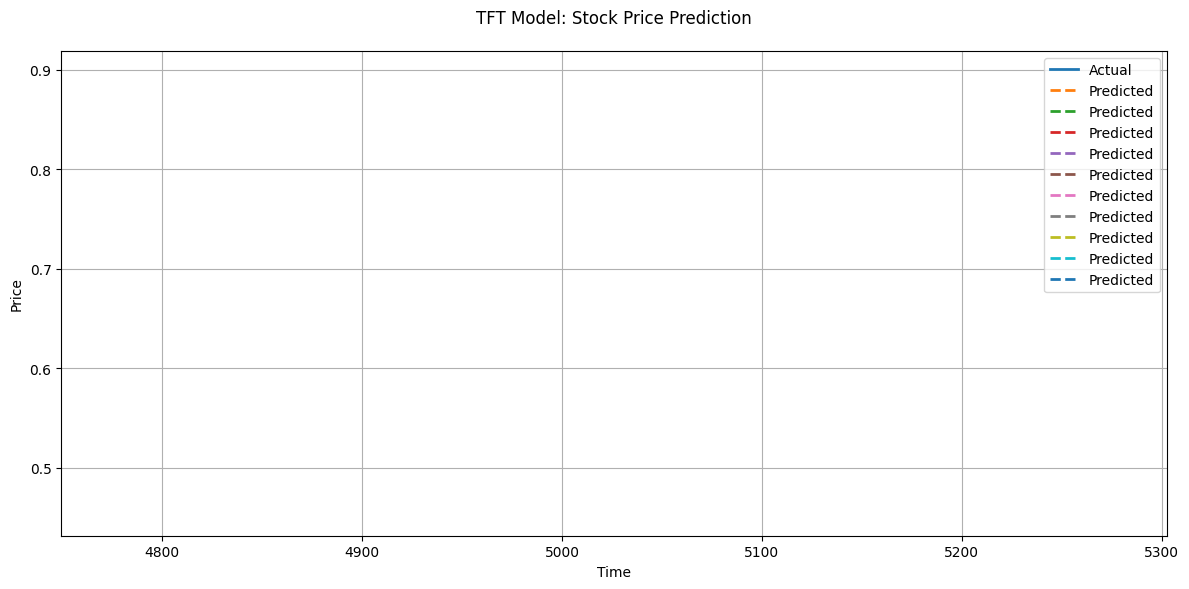

In [90]:
# Required imports
import torch
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Split the data (ensure no shuffling for time series)
train_data, test_data = train_test_split(data_google, test_size=0.2, shuffle=False)

# Add group identifier
train_data['group'] = 'GOOGL'
test_data['group'] = 'GOOGL'

# Update features list
features = ['Open_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Close_GOOGL', 'Volume_GOOGL']
target = 'Close_GOOGL'

# Ensure continuous time index
train_data = train_data.sort_values('time').reset_index(drop=True)
train_data['time'] = range(len(train_data))

test_data = test_data.sort_values('time').reset_index(drop=True)
test_data['time'] = range(len(train_data), len(train_data) + len(test_data))

# Set up model parameters
max_encoder_length = 30
max_prediction_length = 10

# Create TimeSeriesDataSet
training_dataset = TimeSeriesDataSet(
    train_data,
    time_idx="time",
    target=target,
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    time_varying_known_reals=["time"],
    time_varying_unknown_reals=features,
    target_normalizer=GroupNormalizer(
        groups=["group"],
        transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# Create validation dataset
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    train_data, 
    predict=True,
    stop_randomization=True
)

# Create dataloaders
train_dataloader = training_dataset.to_dataloader(
    train=True, 
    batch_size=32,
    num_workers=0,
    shuffle=True
)

validation_dataloader = validation_dataset.to_dataloader(
    train=False, 
    batch_size=32,
    num_workers=0,
    shuffle=False
)

class TFTWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model'])
    
    def on_fit_start(self):
        """Called when fit begins"""
        self.model = self.model.to(self.device)
    
    def _shared_step(self, batch):
        """Common step for training and validation"""
        x, y = batch
        x = {k: v.to(self.device) for k, v in x.items() if isinstance(v, torch.Tensor)}
        if isinstance(y, torch.Tensor):
            y = y.to(self.device)
        # Return both model output and target
        return self.model(x), y
    
    def training_step(self, batch, batch_idx):
        output, y = self._shared_step(batch)
        # Calculate loss using the model's loss function
        loss = self.model.loss(output.prediction, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        output, y = self._shared_step(batch)
        # Calculate loss using the model's loss function
        loss = self.model.loss(output.prediction, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.model.hparams.learning_rate,
            weight_decay=self.model.hparams.weight_decay
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch"
            }
        } 

# Create and configure model
model = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.001,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.5,
    hidden_continuous_size=16,
    loss=QuantileLoss(),
    weight_decay=0.01,
    reduce_on_plateau_patience=5,
    reduce_on_plateau_min_lr=1e-6
)

# Configure trainer
# Update trainer configuration with deterministic settings
trainer = pl.Trainer(
    max_epochs=50,
    gradient_clip_val=0.1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        pl.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            mode="min",
            min_delta=1e-4
        ),
        pl.callbacks.LearningRateMonitor(logging_interval="epoch"),
        pl.callbacks.ModelCheckpoint(
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            filename="{epoch}-{val_loss:.2f}"
        )
    ],
    # Remove deterministic=True and add these settings instead
    enable_checkpointing=True,
    enable_progress_bar=True,
    enable_model_summary=True,
    accumulate_grad_batches=2,
    deterministic=False,  # Changed from True to False
    benchmark=True  # Add this for potential speed improvements
)

# Create wrapped model
wrapped_model = TFTWrapper(model)

# Train model
trainer.fit(wrapped_model, 
           train_dataloaders=train_dataloader, 
           val_dataloaders=validation_dataloader)

# Make predictions with proper device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
with torch.no_grad():
    predictions = model.predict(validation_dataloader)
    # Move predictions to CPU before converting to numpy
    predictions = predictions.cpu()

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(test_data['time'].values[-len(predictions):],
         test_data[target].values[-len(predictions):], 
         label="Actual", 
         linewidth=2)
plt.plot(test_data['time'].values[-len(predictions):],
         predictions, 
         label="Predicted", 
         linewidth=2, 
         linestyle='--')
plt.title("TFT Model: Stock Price Prediction", pad=20)
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MAE: 0.4413
RMSE: 0.4413


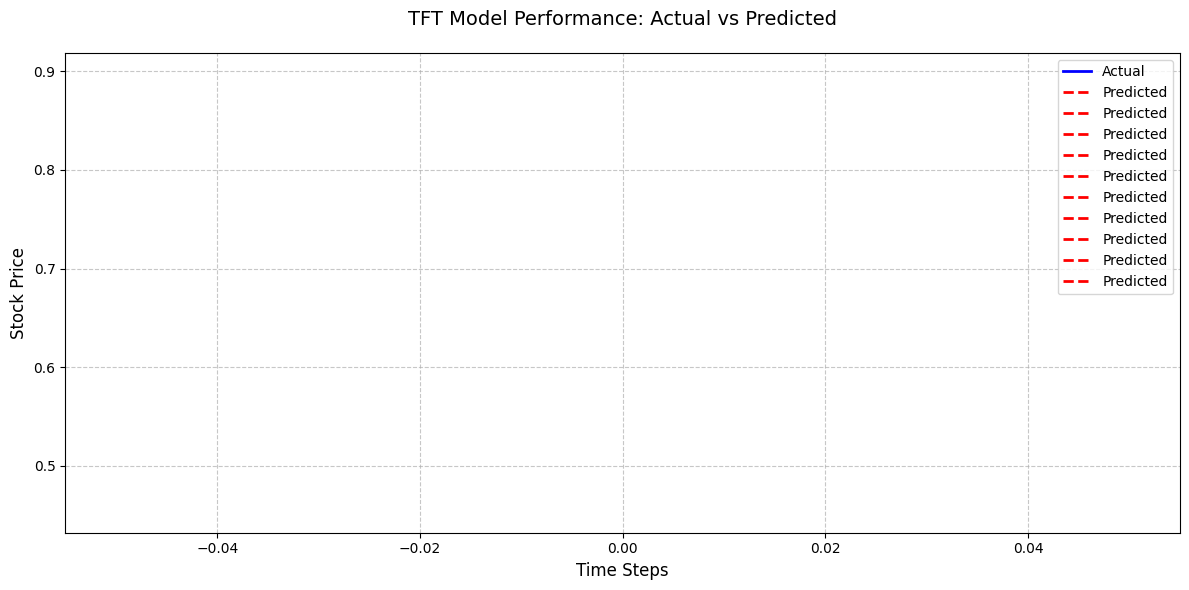

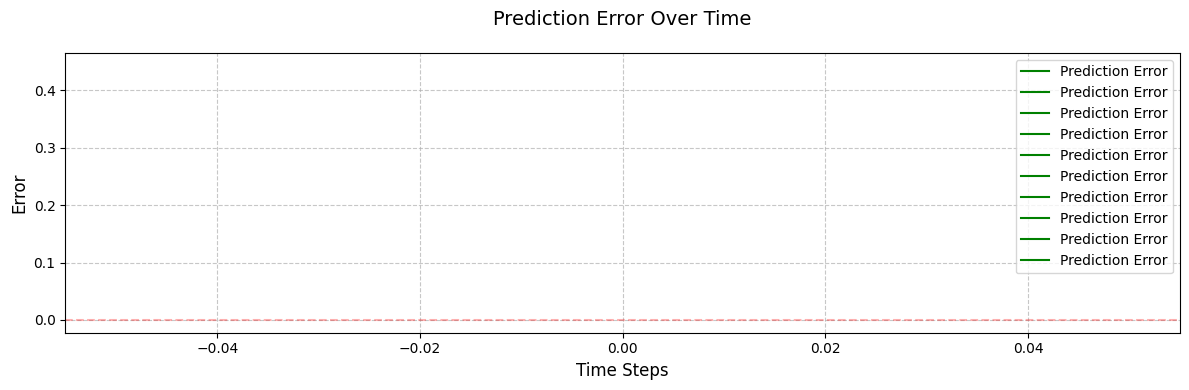

In [91]:
# %% [Cell 7] - Additional Diagnostics

import numpy as np
import matplotlib.pyplot as plt

# Convert predictions to numpy array properly
predicted = predictions.cpu().numpy()  # First move to CPU, then convert to numpy
actual = test_data['Close_GOOGL'].values[-len(predicted):]

# Calculate error metrics
mae = np.mean(np.abs(actual - predicted))
rmse = np.sqrt(np.mean((actual - predicted) ** 2))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Enhanced visualization
plt.figure(figsize=(12, 6))
plt.plot(actual, label="Actual", linewidth=2, color='blue')
plt.plot(predicted, label="Predicted", linewidth=2, color='red', linestyle='--')
plt.title("TFT Model Performance: Actual vs Predicted", size=14, pad=20)
plt.xlabel("Time Steps", size=12)
plt.ylabel("Stock Price", size=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Optional: Plot the prediction error
plt.figure(figsize=(12, 4))
plt.plot(actual - predicted, color='green', label='Prediction Error')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title("Prediction Error Over Time", size=14, pad=20)
plt.xlabel("Time Steps", size=12)
plt.ylabel("Error", size=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()